## COMPAS Dataset Exploration

Amrita Acharya, Dianne Caravela, Elisabeth Nesmith, Emma Kornberg, Eunice Kim with Women At the Table

In [100]:
##Install packages 
!pip install aif360;
!pip install fairlearn;
!pip install 'aif360[AdversarialDebiasing]'

In [101]:
##Install packages to fetch data 
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder

from aif360.datasets import CompasDataset
from aif360.sklearn.datasets import fetch_compas
from aif360.algorithms.inprocessing import MetaFairClassifier

from aif360.sklearn.preprocessing import ReweighingMeta
from aif360.sklearn.inprocessing import AdversarialDebiasing
from aif360.sklearn.postprocessing import CalibratedEqualizedOdds, PostProcessingMeta
from aif360.sklearn.metrics import disparate_impact_ratio, average_odds_error, generalized_fpr, average_odds_difference
from aif360.sklearn.metrics import generalized_fnr, difference, statistical_parity_difference, equal_opportunity_difference, generalized_entropy_error

from IPython.display import Markdown, display

In [102]:
## load in data
## In machine learning tasks, specifically with supervised learning, you have features and labels. 
## The features are the descriptive attributes (they are defined as X), and the label (y) is what you're attempting to predict or forecast

X, y = fetch_compas()
print(f'There are {X.shape[0]} entries and {X.shape[1]} features')
X.head()

There are 6167 entries and 10 features


,,,sex,age,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc
id,sex,race,,,,,,,,,,
1,Male,Other,Male,69,Greater than 45,Other,0,0,0,0,F,Aggravated Assault w/Firearm
3,Male,African-American,Male,34,25 - 45,African-American,0,0,0,0,F,Felony Battery w/Prior Convict
4,Male,African-American,Male,24,Less than 25,African-American,0,0,1,4,F,Possession of Cocaine
7,Male,Other,Male,44,25 - 45,Other,0,0,0,0,M,Battery
8,Male,Caucasian,Male,41,25 - 45,Caucasian,0,0,0,14,F,Possession Burglary Tools


In [103]:
## because our analysis is mainly focusing on how the algorithm treats white and Black people differently, we are
## dropping the rows of data where race != Caucasian or African American
## question: do we need to do this for y as well?
X_new = X[(X.race == "Caucasian") | (X.race == "African-American")]
print(f'There are {X_new.shape[0]} entries and {X_new.shape[1]} features')
X_new.head()

There are 5273 entries and 10 features


,,,sex,age,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc
id,sex,race,,,,,,,,,,
3,Male,African-American,Male,34,25 - 45,African-American,0,0,0,0,F,Felony Battery w/Prior Convict
4,Male,African-American,Male,24,Less than 25,African-American,0,0,1,4,F,Possession of Cocaine
8,Male,Caucasian,Male,41,25 - 45,Caucasian,0,0,0,14,F,Possession Burglary Tools
10,Female,Caucasian,Female,39,25 - 45,Caucasian,0,0,0,0,M,Battery
14,Male,Caucasian,Male,27,25 - 45,Caucasian,0,0,0,0,F,"Poss 3,4 MDMA (Ecstasy)"


In [104]:
## drop unused race categories
# list of categories to be removed
X_new["race"] = X_new["race"].cat.remove_unused_categories()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [105]:
y_new = y[(y.index.get_level_values(2) == "Caucasian") | (y.index.get_level_values(2) == "African-American")]
y_new.head()

id  sex     race            
3   Male    African-American    Recidivated
4   Male    African-American    Recidivated
8   Male    Caucasian           Recidivated
10  Female  Caucasian              Survived
14  Male    Caucasian              Survived
Name: two_year_recid, dtype: category
Categories (2, object): [Survived < Recidivated]

In [106]:
# Function for visualising the confusion matrix and other statistics
# https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

def make_confusion_matrix(cf_matrix, model):
  group_names = ["True Negative","False Positive","False Negative","True Positive"]
  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]

  group_labels = ["{}\n".format(value) for value in group_names]
  group_counts = ["{0:0.0f}\n".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

  box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
  box_labels = np.asarray(box_labels).reshape(cf_matrix.shape[0],cf_matrix.shape[1])


  # add more statistics
  accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
  precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
  recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
  f1_score  = 2*precision*recall / (precision + recall)
  stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
      accuracy,precision,recall,f1_score)


  categories=["Survived", "Recidivated"]
  sns.heatmap(cf_matrix,annot=box_labels,fmt="",cmap='Purples',xticklabels=categories,yticklabels=categories)

  plt.ylabel('True label')
  plt.xlabel('Predicted label' + stats_text)
  plt.title(f"Confusion matrix and statistics for the {model} model");

## defining function for displaying metrics of training and test data by sex 
def metrics_per_group(y_test, y_pred):
	# y true per group
	y_test_white = y_test.loc[y_test.index.get_level_values(2) == 2]
	y_test_black = y_test.loc[y_test.index.get_level_values(2) == 0]

	# y_pred per group
	y_pred_white = y_pred[y_test.index.get_level_values(2) == 2]
	y_pred_black = y_pred[y_test.index.get_level_values(2) == 0]

	# metrics
	scores = []
	scores.append(accuracy_score(y_test, y_pred))
	scores.append(recall_score(y_test, y_pred))
	scores.append(precision_score(y_test, y_pred))

	scores.append(accuracy_score(y_test_black, y_pred_black))
	scores.append(recall_score(y_test_black, y_pred_black))
	scores.append(precision_score(y_test_black, y_pred_black))

	scores.append(accuracy_score(y_test_white, y_pred_white))
	scores.append(recall_score(y_test_white, y_pred_white))
	scores.append(precision_score(y_test_white, y_pred_white))

	attribute = ["all"]*3 + ["black"] *3 + ["white"] *3
	metric = ["accuracy", "recall", "precision"] * 3
	  
	# dictionary of lists 
	dict = {'race': attribute, 'metrics': metric, 'score': scores} 
	    
	df = pd.DataFrame(dict)

	sns.barplot(x = "metrics", y = "score", hue = "race", data = df, palette = ['#dfcd1a', '#9d0677', '#236c48'])
	plt.title("Performance metrics by groups")
 

def plot_fair_metrics(fair_metrics_mitigated, model): 
  cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'generalized_entropy']
  obj_fairness = [[0,0,1]]

  # row for objectives    
  fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
      
  # row for baseline model
  fair_metrics.loc['Baseline Model'] = [stat_par_diff, eq_opp_diff, gen_entr_error]

  # row for mitigated bias
  fair_metrics.loc[model] = fair_metrics_mitigated


  metrics_len = len(cols)


  fig, ax = plt.subplots(figsize=(20,4), ncols=metrics_len, nrows=1)

  plt.subplots_adjust(
      left    =  0.125, 
      bottom  =  0.1, 
      right   =  0.9, 
      top     =  0.9, 
      wspace  =  .5, 
      hspace  =  1.1
  )

  y_title_margin = 1.2

  plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
  sns.set(style="dark")

  cols = fair_metrics.columns.values
  obj = fair_metrics.loc['objective']
  size_rect = [0.2,0.2,0.2,0.4,0.25]
  rect = [-0.1,-0.1,-0.1,0.8,0]
  bottom = [-1,-1,-1,0,0]
  top = [1,1,1,2,1]
  bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

  for i in range(0,metrics_len):
      plt.subplot(1, metrics_len, i+1)
      ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
      
      for j in range(0,len(fair_metrics)-1):
          a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
          marg = -0.2 if val < 0 else 0.1
          ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

      plt.ylim(bottom[i], top[i])
      plt.setp(ax.patches, linewidth=0)
      ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
      plt.axhline(obj[i], color='black', alpha=0.3)
      plt.title(cols[i])
      ax.set_ylabel('')    
      ax.set_xlabel('')

In [107]:
X_new.index = pd.MultiIndex.from_arrays(X_new.index.codes, names=X_new.index.names)
y_new.index = pd.MultiIndex.from_arrays(y_new.index.codes, names=y_new.index.names)
# 0 is African American, 2 is Caucasian

In [108]:
# set target class to 0/1 -- not sure what this line does
y_new = pd.Series(y_new.factorize(sort=True)[0], index=y_new.index)

# Exploratory Data Analysis

In [109]:
## need to figure out how to keep other race categories from showing up 
df_viz = X_new.copy()
df_viz['race'] = X_new['race'].replace({2.0: 'Caucasian', 0.0: 'African-American'})
df_viz['two_year_recid'] = y_new.replace({1:'Recidivated', 0: 'Survived'})
df_viz.index = df_viz.index.droplevel('race')

purple = '#9d0677'
green = '#30875c'
workshop_palette = [purple, green]
df_viz.head()

,,sex,age,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,two_year_recid
id,sex,,,,,,,,,,,
1,0,Male,34,25 - 45,African-American,0,0,0,0,F,Felony Battery w/Prior Convict,Recidivated
2,0,Male,24,Less than 25,African-American,0,0,1,4,F,Possession of Cocaine,Recidivated
4,0,Male,41,25 - 45,Caucasian,0,0,0,14,F,Possession Burglary Tools,Recidivated
6,1,Female,39,25 - 45,Caucasian,0,0,0,0,M,Battery,Survived
7,0,Male,27,25 - 45,Caucasian,0,0,0,0,F,"Poss 3,4 MDMA (Ecstasy)",Survived


Text(0.5, 1.0, 'Two Year Recidivism Rate')

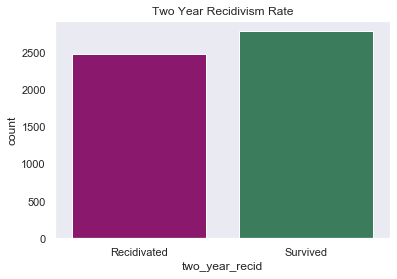

In [110]:
# barplot of recividism
sns.countplot(x='two_year_recid', data=df_viz, palette=workshop_palette)
plt.title('Two Year Recidivism Rate')

Text(0.5, 1.0, 'Race Distribution (White and Black individuals only)')

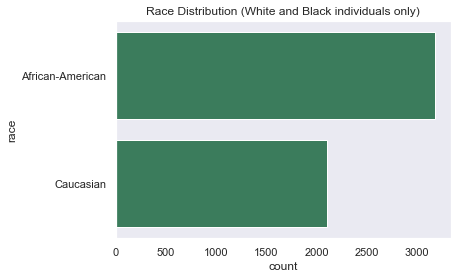

In [111]:
# barplot of race
sns.countplot(y="race", data=df_viz, palette=["#30875c"])
plt.title('Race Distribution (White and Black individuals only)')

ValueError: could not convert string to float: 'Male'

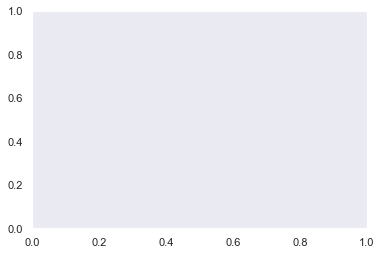

In [112]:
# age distribution by race
ax = sns.kdeplot(x="age", hue="race", data=df_viz);
kdeline = ax.lines[0]
mean_fem = df_viz.groupby('race').age.median()[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
height_fem = np.interp(mean_fem, xs, ys)
ax.vlines(mean_fem, 0, height_fem, color=purple, ls=':')

mean_m = df_viz.groupby('race').age.median()[1]
height_m = np.interp(mean_m, xs, ys)
ax.vlines(mean_m, 0, height_m, color=green, ls=':')


print(df_viz.groupby('race').age.median())

plt.title('Distribution of Age by Race')

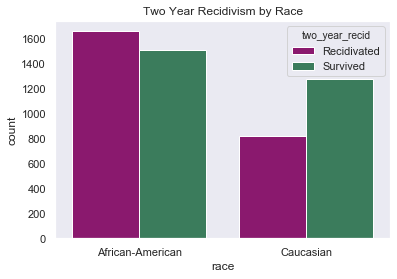

In [113]:
# recividism by race
by_sex = sns.countplot(x="race", hue="two_year_recid", data=df_viz, palette=workshop_palette)

plt.title('Two Year Recidivism by Race')
plt.show()

# Baseline Metrics

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, random_state=1234567)

# one-hoy encode the categorical features
data_preproc = make_column_transformer(
        (OneHotEncoder(sparse=False, handle_unknown='ignore'), X_train.dtypes == 'category'))

X_train = pd.DataFrame(data_preproc.fit_transform(X_train), index=X_train.index)
X_test = pd.DataFrame(data_preproc.transform(X_test), index=X_test.index)

# to save the information for the column names
pd.get_dummies(X_new).head()

,,,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,sex_Male,sex_Female,age_cat_25 - 45,age_cat_Greater than 45,age_cat_Less than 25,...,c_charge_desc_Video Voyeur-<24Y on Child >16,c_charge_desc_Viol Injunct Domestic Violence,c_charge_desc_Viol Injunction Protect Dom Vi,c_charge_desc_Viol Pretrial Release Dom Viol,c_charge_desc_Viol Prot Injunc Repeat Viol,c_charge_desc_Violation License Restrictions,c_charge_desc_Violation Of Boater Safety Id,c_charge_desc_Violation of Injunction Order/Stalking/Cyberstalking,c_charge_desc_Voyeurism,c_charge_desc_arrest case no charge
id,sex,race,,,,,,,,,,,,,,,,,,,,,
1,0,0,34,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,24,0,0,1,4,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,2,41,0,0,0,14,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,2,39,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,2,27,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [115]:
from aif360.sklearn.preprocessing import ReweighingMeta, Reweighing
from sklearn.metrics import accuracy_score, confusion_matrix, plot_roc_curve, recall_score, precision_score


lr = LogisticRegressionCV(solver='lbfgs')
reg = lr.fit(X_train, y_train)
y_pred = reg.predict(X_test)

acc_base = accuracy_score(y_test, y_pred)
print(f'[Baseline] The test accuracy of the algorithm is: {acc_base: .2%}')

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

[Baseline] The test accuracy of the algorithm is:  61.26%


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


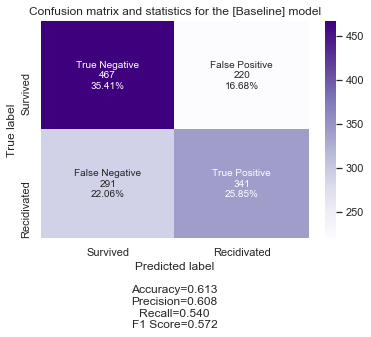

In [93]:
##Sex predicting score 
##Look at 2nd column of matrix for precision 
##2nd row of matrix for recall 
cf_matrix = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix, "[Baseline]")

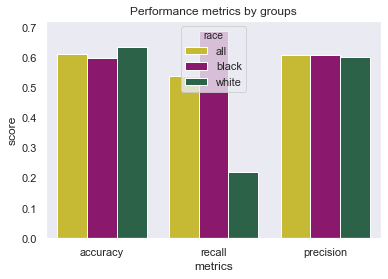

In [116]:
metrics_per_group(y_test, y_pred)

In the black population, the model identifies 70% of recidivated guesses correctly. In the black population, the model identifies 20% of recidivated guesses correctly. 

In [117]:
stat_par_diff = statistical_parity_difference(y_test, prot_attr='sex')

print(f'[Baseline] The statistical parity difference is {stat_par_diff: .2}')

[Baseline] The statistical parity difference is  0.15


In [118]:
gen_entr_error = generalized_entropy_error(y_test, y_pred, alpha=1)

print(f'[Baseline] The generalized entropy error is {gen_entr_error: .2}')

[Baseline] The generalized entropy error is  0.3


In [119]:
eq_opp_diff = equal_opportunity_difference(y_test, y_pred, prot_attr='sex')

print(f'[Baseline] The equal opportunity difference is {eq_opp_diff: .2}')

[Baseline] The equal opportunity difference is  0.44


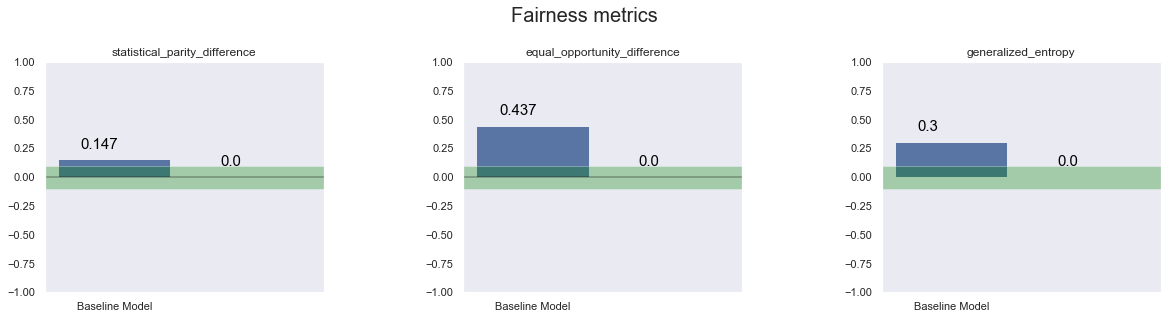

In [120]:
plot_fair_metrics([0, 0, 0], '')

# Pre-Processing Approach

In [121]:
lr = LogisticRegression(solver='lbfgs')
rew = ReweighingMeta(estimator=lr, reweigher=Reweighing('race'))
rew.fit(X_train, y_train)
y_pred_REW = rew.predict(X_test)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [122]:
acc_REW = accuracy_score(y_test, y_pred_REW)
print(f'[Reweighting] The test accuracy of the algorithm is: {acc_REW: .2%}')

[Reweighting] The test accuracy of the algorithm is:  60.58%


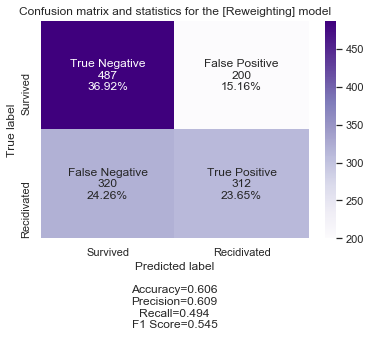

In [123]:
cf_matrix = confusion_matrix(y_test, y_pred_REW)
make_confusion_matrix(cf_matrix, "[Reweighting]")

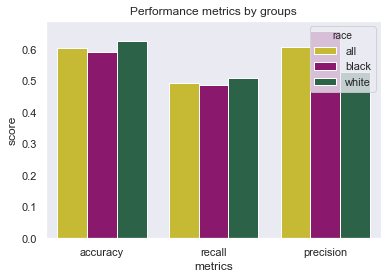

In [124]:
metrics_per_group(y_test, y_pred_REW)

In [125]:
stat_par_diff_RW = statistical_parity_difference(y_test, y_pred_REW, prot_attr='sex')
print(f'[Reweighting] The statistical parity difference is {stat_par_diff_RW: .2}')

[Reweighting] The statistical parity difference is  0.31


In [126]:
eq_opp_diff_RW = equal_opportunity_difference(y_test, y_pred_REW, prot_attr='sex')

print(f'[Reweighting] The equal opportunity difference is {eq_opp_diff_RW: .2}')

[Reweighting] The equal opportunity difference is  0.31


In [127]:
gen_entr_error_RW = generalized_entropy_error(y_test, y_pred_REW, alpha=1)


print(f'[Reweighting] The generalized entropy error is {gen_entr_error_RW: .2}')

[Reweighting] The generalized entropy error is  0.33


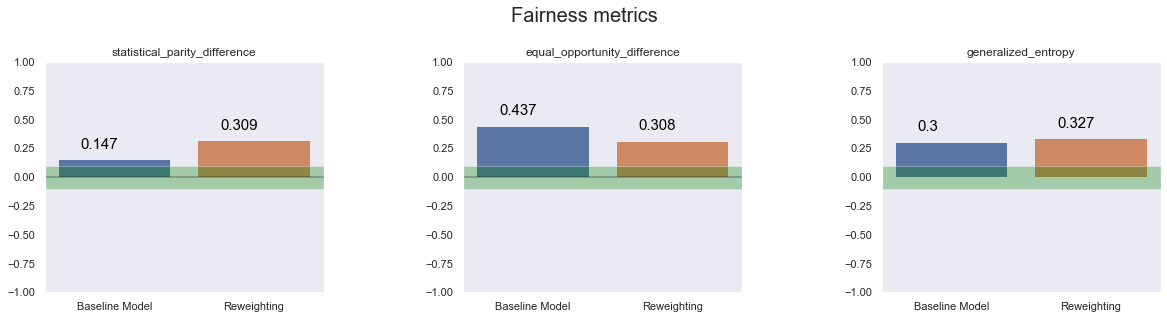

In [128]:
plot_fair_metrics([stat_par_diff_RW, eq_opp_diff_RW, gen_entr_error_RW], 'Reweighting')

# In-Processing

In [134]:
df_train = X_train.copy()
df_train["credit_score"] = y_train
df_train.rename(columns={51:'race'}, inplace=True)
df_train = df_train.reset_index(drop=True)

df_test = X_test.copy()
df_test["two_year_recid"] = y_test
df_test = df_test.reset_index(drop=True)
df_test.rename(columns={51:'race'}, inplace=True)

In [138]:
train_BLD = CompasDataset(favorable_label='1',
                                unfavorable_label='0',
                                df=df_train,
                                label_names=['two_year_recid'],
                                protected_attribute_names=['race'])

test_BLD = CompasDataset(favorable_label='1',
                                unfavorable_label='0',
                                df=df_test,
                                label_names=['two_year_recid'],
                                protected_attribute_names=['race'])

TypeError: __init__() got an unexpected keyword argument 'favorable_label'

In [139]:
meta = MetaFairClassifier(tau=0.8, sensitive_attr='race', type='fdr', seed=1234567)

meta.fit(train_BLD)
y_pred_META = meta.predict(test_BLD)
y_pred_META = y_pred_META.labels.flatten()

NameError: name 'train_BLD' is not defined

In [140]:
acc_AD = accuracy_score(y_test, y_pred_META)
print(f'[ Meta-Classification] The test accuracy of the algorithm is: {acc_AD: .2%}')

NameError: name 'y_pred_META' is not defined

# Post-Processing 

In [129]:
from aif360.sklearn.postprocessing import CalibratedEqualizedOdds, PostProcessingMeta

pp = CalibratedEqualizedOdds('race', cost_constraint='fnr', random_state=1234567)
ceo = PostProcessingMeta(estimator=lr, postprocessor=pp, random_state=1234567)
ceo.fit(X_train, y_train)
y_pred_CEO = ceo.predict(X_test)
y_proba_CEO = ceo.predict_proba(X_test)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [130]:
acc_CEO = accuracy_score(y_test, y_pred_CEO)
print(f'[Calibrated Equalized Odds] The test accuracy of the algorithm is: {acc_CEO: .2%}')

[Calibrated Equalized Odds] The test accuracy of the algorithm is:  53.22%


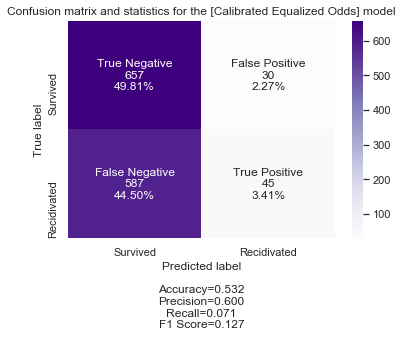

In [131]:
cf_matrix = confusion_matrix(y_test, y_pred_CEO)
make_confusion_matrix(cf_matrix, "[Calibrated Equalized Odds]")

In [132]:
stat_par_diff_CEO = statistical_parity_difference(y_test, y_pred_CEO, prot_attr='sex')

print(f'[Calibrated Equalized Odds] The statistical parity difference is {stat_par_diff_CEO: .2}')

[Calibrated Equalized Odds] The statistical parity difference is  0.038


In [133]:
eq_opp_diff_CEO = equal_opportunity_difference(y_test, y_pred_CEO, prot_attr='sex')

print(f'[Calibrated Equalized Odds] The equal opportunity difference is {eq_opp_diff_CEO: .2}')

[Calibrated Equalized Odds] The equal opportunity difference is  0.047


In [ ]:
plot_fair_metrics([stat_par_diff_CEO, eq_opp_diff_CEO, gen_entr_error_CEO], 'Calibrated Equalized Odds')